In [1]:
import numpy as np
from lensing_data_class import LensingData
from cluster_local_tidy import ClusterLensing
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import lenstronomy.Util.constants as const
import pandas as pd
import corner
import arviz as az
import pathlib

In [2]:
import warnings

# Suppressing the lenstronomy warning on astropy.cosmology
from lenstronomy.LensModel.lens_model import LensModel
warnings.filterwarnings("ignore", category=UserWarning, module='lenstronomy.LensModel.lens_model')

# Lens data

scenarios = {
        '1': 'abell370',
        '2': 'abell2744',
        '3': 'abells1063',
        '4': 'macs0416',
        '5': 'macs0717',
        '6': 'macs1149'
    }

full_cluster_names = {
        'abell370': 'Abell 370',
        'abell2744': 'Abell 2744',
        'abells1063': 'Abell S1063',
        'macs0416': 'MACS J0416.1-2403',
        'macs0717': 'MACS J0717.5+3745',
        'macs1149': 'MACS J1149.5+2223'
    }

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []
data_sigma_dt_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_psi.fits'
    )
    sigma_dt_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/cats copy/hlsp_frontier_model_{clustername}_cats_v4_sigma_dt.fits'
    )   

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi, fits.open(sigma_dt_file) as hdul_sigma_dt:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data
        data_sigma_dt = hdul_sigma_dt[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)
        data_sigma_dt_list.append(data_sigma_dt)

# getting the pixel scale list
pixscale_list = [0.2, 0.3, 0.2, 0.3, 0.8, 0.5]
lensing_data = LensingData(
    alpha_maps_x=datax_list,
    alpha_maps_y=datay_list,
    lens_potential_maps=data_psi_list,
    uncertainty_dt=data_sigma_dt_list,
    pixscale = pixscale_list,
    z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543], # Lens redshifts for the two clusters
    # We can use the default x_center, y_center, and search_window_list
    # or override them if needed.
)

# --- 3. Initialize the Main Analysis Class ---
# z_s_ref is a reference source redshift used for initial scaling calculations.
# It can be an estimate of the source's redshift.
z_s_ref = 1.5 
cluster_system = ClusterLensing(data=lensing_data, z_s_ref=z_s_ref)

print("Setup complete. Lensing system initialized.")

Setup complete. Lensing system initialized.


In [3]:
# Get the result from csv file
csv_file_path = os.path.join(os.getcwd(), 'src_pos_tidy_xyz.csv')
localized_data = pd.read_csv(csv_file_path)
# Assuming the CSV has columns 'x_src', 'y_src', 'z_s' for each cluster
index = localized_data['indices'].values
x = localized_data['x'].values
y = localized_data['y'].values
z = localized_data['z'].values
H0 = 70

lum_dist_true = []
time_delays_true = []
for i in range(len(x)):
    test_params = {"x_src" : x[i], "y_src": y[i], "z_s": z[i], "H0": H0}
    test_cluster = int(index[i])
    # Calculate the image positions and time delays for the test parameters
    output = cluster_system.calculate_imgs_delays_magns(
        test_params, test_cluster
    )
    
    cosmos = FlatLambdaCDM(H0=70, Om0=0.3)
    lum_dist_unlensed = cosmos.luminosity_distance(z[i]).value  # Luminosity distance in Mpc
    mu = output['magnifications']
    lum_dist_lensed = np.array([lum_dist_unlensed / np.abs(m) for m in mu])
    lum_dist_true.append(lum_dist_lensed)
    time_delays_true.append(output['time_delays'])
# # test image pos and dt
# index, x,y,z,H0 =3, 125.1862426095528,108.72131582359688,2.937492820554342, 70
# #print(x[0], y[0], z[0], H0)
# test_params = {"x_src" : x, "y_src": y, "z_s": z, "H0": H0}
# test_cluster = index
# # Calculate the image positions and time delays for the test parameters
# output = cluster_system.calculate_imgs_delays_magns(
#     test_params, test_cluster
# )
# print(output['time_delays'])
# print(output['image_positions'])
# print(output['magnifications'])
# dt_true = output['time_delays']

# # get its luminosity distance
# cosmos = FlatLambdaCDM(H0=70, Om0=0.3)
# lum_dist_unlensed = cosmos.luminosity_distance(z).value  # Luminosity distance in Mpc
# mu = output['magnifications']
# lum_dist_true = np.array([lum_dist_unlensed / np.abs(m) for m in mu])
# print("True luminosity distances:", lum_dist_unlensed)
# print("Lensed luminosity distances:", lum_dist_true)


KeyboardInterrupt: 

In [16]:
# get the localized x, y and z from the csv.file
localized_index = localized_data['localized_index'].values
localized_x = localized_data['localized_x'].values
localized_y = localized_data['localized_y'].values
localized_z = localized_data['localized_z'].values
# test chi sq calculation
chi_sqs = []
for i in range(len(localized_index)):
    test_params_chi_sq = {
        "x_src": localized_x[i], 
        "y_src": localized_y[i], 
        "z_s": localized_z[i], 
        "H0": H0
    }
    chi_sq_value = cluster_system._calculate_chi_squared(
        params=test_params_chi_sq,
        dt_true=time_delays_true[i],
        index=int(localized_index[i]),
        sigma_lum=0.1,
        lum_dist_true=lum_dist_true[i]
    )
    if chi_sq_value < 10000:
        chi_sqs.append(chi_sq_value)

print(len(chi_sqs))



59


In [18]:
# save the chi sq values to the csv
localized_data['chi_sq'] = pd.Series(chi_sqs)
#print(localized_data)
localized_data.to_csv('src_pos_tidy_xyz.csv', index=False)

In [6]:
# merge the second smallest chi sq values from the second_smallest.csv file to the src_pos_tidy_xyz.csv file
second_smallest_df = pd.read_csv('/home/dices/Research/GWlensing_Brian/with_z/second_smallest.csv')
# Assuming the file_number corresponds to the index in localized_data
localized_data = pd.read_csv('src_pos_tidy_xyz.csv')
# Create a 'file_number' column in localized_data that corresponds to its row index
localized_data['file_number'] = localized_data.index

# Merge the two dataframes on the 'file_number' column
# 'how=left' ensures all rows from localized_data are kept
merged_df = pd.merge(localized_data, second_smallest_df, on='file_number', how='left')
# delete the 'file_number' column as it's no longer needed
merged_df = merged_df.drop(columns=['file_number'])
# Save the merged dataframe to the existing CSV file
merged_df.to_csv('src_pos_tidy_xyz.csv', index=False)

print("Merge complete. Data saved to 'src_pos_tidy_xyz.csv'")
print(merged_df.head())

Merge complete. Data saved to 'src_pos_tidy_xyz.csv'
   indices          x          y         z  localized_index  localized_x  \
0      0.0  78.992149  70.294558  3.113992              0.0    78.989132   
1      0.0  73.734132  81.108082  3.787066              0.0    73.734923   
2      0.0  74.653888  79.557803  2.897888              0.0    74.658417   
3      0.0  80.860983  80.465616  3.278544              0.0    80.835101   
4      0.0  79.381339  78.546732  3.985365              0.0    79.374083   

   localized_y  localized_z run_status  run_msg  localized_H0    chi_sq  \
0    70.315411     3.118204         OK      NaN           0.0  0.033402   
1    81.111714     3.782244         OK      NaN           0.0  0.003673   
2    79.555887     2.894090         OK      NaN           0.0  0.179032   
3    80.434196     3.289421         OK      NaN           0.0  0.740185   
4    78.521365     4.011994         OK      NaN           0.0  0.396887   

   accepted_clusters                   

In [ ]:
#calculating the difference between the smallest chi sq and the second smallest chi sq
merged_data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = merged_data['second_smallest_chi2'] - merged_data['chi_sq']
merged_data['bayes_factor'] = bayes_factors
merged_data.to_csv('src_pos_tidy_xyz.csv', index=False)

[ 48.47654925  39.22142477  28.00159344  20.52362523  16.13982592
  23.91866975  42.52192763  52.33148833  15.74640263  50.31201414
 216.59168574 222.53063808 315.72010873 172.93526133 156.73733856
 293.13347252 125.42728924  12.38126177   6.26569627  57.07402584
  24.34727811  10.3080568   86.04312717 163.56963136  29.01512923
  13.04339401  54.32108745  11.14975797  21.78835692  23.26245255
  34.41323494  10.89454464  31.71860558   8.57243934  44.95440124
 388.19118606  14.78752818  45.1809678  184.03549176 129.69871237
  46.87428572 143.06449942  28.69011556  13.12214878  15.02570727
 219.84207751  18.37521871   7.67176854]


Text(0.5, 0, '$log_{10} \\mathcal{B}$ ($\\delta \\chi^2$)')

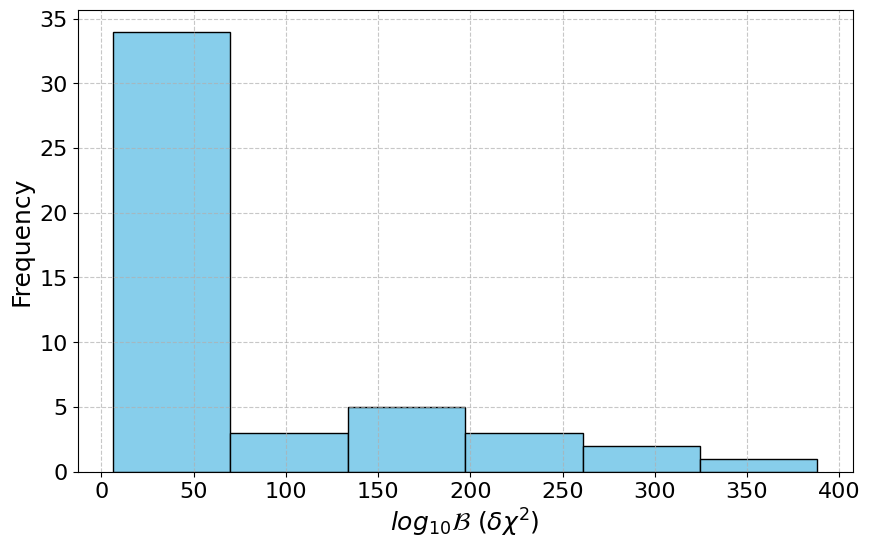

In [ ]:
# making the bayes factor histogram plot
data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = data['bayes_factor'].values
# opt out the bayes_factor values if the value of chi_sq in the same row is larger than 100
chi_sq_values = data['chi_sq'].values
bayes_factors = bayes_factors[chi_sq_values <= 20]
# bayes_factor are in ln base, change to log 10 base
bayes_factors *= np.log10(np.e)
#print(bayes_factors)

# getting the bin number using Freedman-Diaconis rule
def freedman_diaconis(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(data) ** (-1/3)
    bin_count = int((data.max() - data.min()) / bin_width)
    return bin_count


plt.figure(figsize=(10, 6))
plt.hist(bayes_factors, color='skyblue', edgecolor='black', bins=freedman_diaconis(bayes_factors))
# add grid lines in x and y direction
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# set the font size of the ticks
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel(r'$log_{10} \mathcal{B}$ ($\delta \chi^2$)', fontsize=18)

#plt.savefig('Report images sem2/new/bayes_factor_histogram_xyz.pdf', bbox_inches='tight')


Number of filtered npz files: 48


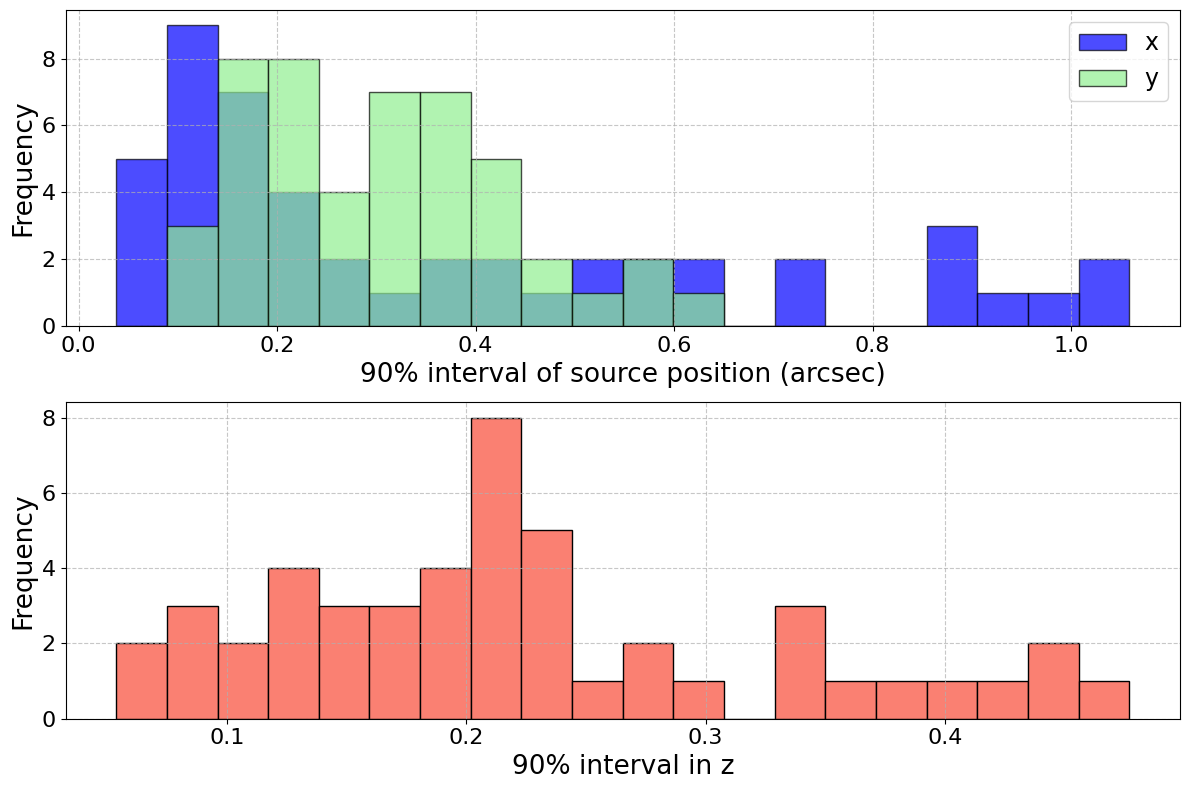

In [3]:
import glob
from matplotlib.ticker import MaxNLocator
# make the plot of uncertainty in histogram
# get all the npz file from the folder
OUT_DIR = '/home/dices/Research/GWlensing_Brian/outputs/out_xyz'
# Search for .npz files in subdirectories matching the pattern 'row*'
npz_files = glob.glob(os.path.join(OUT_DIR, 'row*','test_tidy_row*', '*.npz'))
# drop the npz files if its folder contains more than 1 .npz file, or the corresponding chi sq value is larger than 20 in the corresponding src_pos_tidy_xyz.csv file
filtered_npz_files = []
accepted_rows = []
localized_data = pd.read_csv('src_pos_tidy_xyz.csv')
for npz_file in npz_files:
    # extract the row number from the npz file path
    row_number = int(pathlib.Path(npz_file).parts[-3][3:])  # 'rowX' -> X
    # get the chi sq value from the localized_data dataframe
    chi_sq_value = localized_data.loc[row_number, 'chi_sq']
    # count the number of npz files in the same folder
    folder_path = os.path.dirname(npz_file)
    num_npz_in_folder = len(glob.glob(os.path.join(folder_path, '*.npz')))
    if chi_sq_value <= 20 and num_npz_in_folder == 1:
        filtered_npz_files.append(npz_file)
        accepted_rows.append(row_number)

print(f"Number of filtered npz files: {len(filtered_npz_files)}")


all_uncertainties = []

# get the uncertainty from each npz file
for npz_file in filtered_npz_files:
    mcmc_data = np.load(npz_file)
    flat_chain = mcmc_data['flat_chain']
    # calculate the 90% credible interval as the uncertainty for the 3 parameters in the npz file
    uncertainty = np.percentile(flat_chain, 95, axis=0) - np.percentile(flat_chain, 5, axis=0)
    all_uncertainties.extend(uncertainty)
# rearrange the uncertainties into 3 separate lists for x, y, z, when the elements are arranged in [[x, y, z], [x, y, z],...]
uncertainties = np.array(all_uncertainties).reshape(-1, 3)
uncertainties_x = uncertainties[:, 0]
uncertainties_y = uncertainties[:, 1]
uncertainties_z = uncertainties[:, 2]
#print(uncertainties_x)
# plot the histogram of the uncertainties
fig, axs = plt.subplots(2, 1, figsize=(12, 8), tight_layout=True)

# Plot for x and y uncertainties combined
# Determine common bins for x and y uncertainties to ensure same bin widths
min_val = min(uncertainties_x.min(), uncertainties_y.min())
max_val = max(uncertainties_x.max(), uncertainties_y.max())
bins = np.linspace(min_val, max_val, 21)  # 20 bins

axs[0].hist(uncertainties_x, bins=bins, color='blue', edgecolor='black', alpha=0.7, label='x')
axs[0].hist(uncertainties_y, bins=bins, color='lightgreen', edgecolor='black', alpha=0.7, label='y')
axs[0].set_xlabel('90% interval of source position (arcsec)', fontsize=19)
axs[0].set_ylabel('Frequency', fontsize=19)
axs[0].grid(axis='both', linestyle='--', alpha=0.7)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=17)
axs[0].yaxis.set_major_locator(MaxNLocator(nbins=6,integer=True))

# Plot for z uncertainty
axs[1].hist(uncertainties_z, bins=20, color='salmon', edgecolor='black')
axs[1].set_xlabel('90% interval in z', fontsize=19)
axs[1].set_ylabel('Frequency', fontsize=19)
axs[1].grid(axis='both', linestyle='--', alpha=0.7)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].yaxis.set_major_locator(MaxNLocator(nbins=6,integer=True))

plt.savefig('Report images sem2/new/90_interval_xyz.pdf', bbox_inches='tight')


Number of filtered bayes factors: 48
[np.float64(7.2969658472580035), np.float64(5.446473932894021), np.float64(4.292663398064214), np.float64(7.176442692121459), np.float64(5.273532547431709), np.float64(6.167850448332368), np.float64(10.207205633245817), np.float64(5.2081185768940665), np.float64(6.9471953578816805), np.float64(5.071204845995405), np.float64(6.642873539092198), np.float64(5.73711641273359), np.float64(5.307334512657252), np.float64(6.014063260753943), np.float64(7.374146198053438), np.float64(6.245087062658233), np.float64(6.513608084270111), np.float64(13.009833357339707), np.float64(10.13805397755221), np.float64(4.375561894073339), np.float64(7.60853483009769), np.float64(4.660860313880737), np.float64(6.334199865556752), np.float64(5.0789767217569315), np.float64(3.9429279531418078), np.float64(5.00913038534282), np.float64(3.326415186644601), np.float64(4.1331115303511226), np.float64(4.046291243636012), np.float64(3.861739560304004), np.float64(6.05675321793322

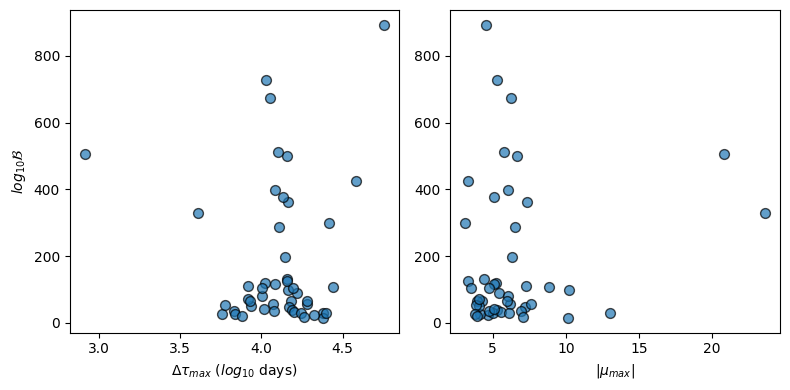

In [15]:
# get the correlation map between the relative time delays, largest relative magnifications, and the bayes factor of the 60 events
# get the bayes factor from the src_pos_tidy_xyz.csv file
data = pd.read_csv('src_pos_tidy_xyz.csv')
bayes_factors = data['bayes_factor'].values
localized_index = data['localized_index'].values
localized_x = data['localized_x'].values
localized_y = data['localized_y'].values
localized_z = data['localized_z'].values
# opt out the bayes_factor values if the value of chi_sq in the same row is larger than 20 or the number of .npz files in the corresponding folder is more than 1
chi_sq_values = data['chi_sq'].values
filtered_bayes_factors = []
filtered_localized_index = []
filtered_localized_x = []
filtered_localized_y = []
filtered_localized_z = []
for i in range(len(bayes_factors)):
    row_number = i
    chi_sq_value = chi_sq_values[i]
    folder_path = os.path.join(OUT_DIR, f'row{row_number}', f'test_tidy_row{row_number}')
    num_npz_in_folder = len(glob.glob(os.path.join(folder_path, '*.npz')))
    if chi_sq_value <= 20 and num_npz_in_folder == 1:
        filtered_bayes_factors.append(bayes_factors[i])
        filtered_localized_index.append(localized_index[i])
        filtered_localized_x.append(localized_x[i])
        filtered_localized_y.append(localized_y[i])
        filtered_localized_z.append(localized_z[i])
print(f"Number of filtered bayes factors: {len(filtered_bayes_factors)}")

# get the image positions, time delays, and magnifications from each x,y,z pair with the index
image_positions = []
time_delays = []
magnifications = []
for i in range(len(filtered_localized_x)):
    x = filtered_localized_x[i]
    y = filtered_localized_y[i]
    z = filtered_localized_z[i]
    index = filtered_localized_index[i]
    # use the clusterlensing class to calculate the image positions, time delays, and magnifications
    test_params = {"x_src" : x, "y_src": y, "z_s": z, "H0": 70}
    test_cluster = int(index)
    output = cluster_system.calculate_imgs_delays_magns(
        test_params, test_cluster
    )
    image_positions.append(output['image_positions'])
    largest_time_delay = np.max(output['time_delays']) - np.min(output['time_delays'])
    largest_magnification = np.max(np.abs(output['magnifications']))
    time_delays.append(largest_time_delay)
    magnifications.append(largest_magnification)

# print(time_delays)
print(magnifications)

# plot the graph between the time delays, magnifications, and bayes factors separately by scatter plot
fig,axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
axs[0].scatter(np.log10(time_delays), filtered_bayes_factors, s=50, marker='o',edgecolor='k', alpha=0.7)
axs[0].set_xlabel(r'$\Delta \tau_{max}$ ($log_{10}$ days)')
axs[0].set_ylabel(r'$log_{10} \mathcal{B}$')

axs[1].scatter(magnifications, filtered_bayes_factors, s=50, marker='o', edgecolor='k', alpha=0.7)
axs[1].set_xlabel(r'$|\mu_{max}|$')

plt.tight_layout()
#plt.savefig('Report images sem2/new/B_vs_dt_mu_xyz.pdf', bbox_inches='tight')

In [ ]:
# plot the time delay uncertainty, cluster size, z_s vs bayes factor
# get the time delat uncertainty of each image position

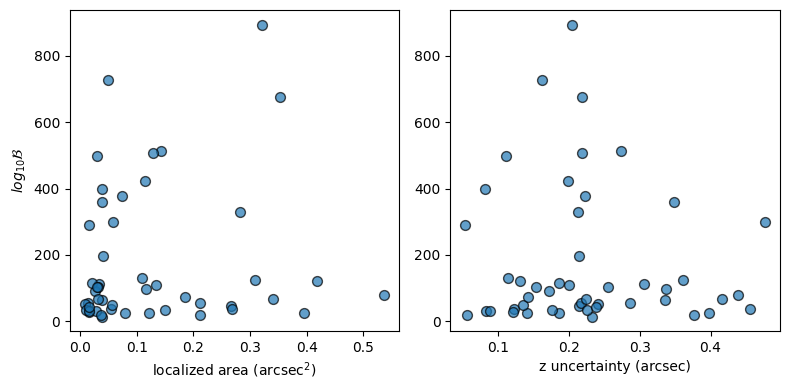

In [6]:
# plot the the graph between the 90% credible intervals, and bayes factors separately by scatter plot
# make the credible interval of x and y into the localized area in arcsec^2
localized_area = [uncertainties_x[i] * uncertainties_y[i] for i in range(len(uncertainties_x))]
    
fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
axs[0].scatter(localized_area, filtered_bayes_factors, s=50, marker='o', edgecolor='k', alpha=0.7)
axs[0].set_xlabel('localized area (arcsec$^2$)')
axs[0].set_ylabel(r'$log_{10} \mathcal{B}$')

axs[1].scatter(uncertainties_z, filtered_bayes_factors, s=50, marker='o', edgecolor='k', alpha=0.7)
axs[1].set_xlabel('z uncertainty (arcsec)')

plt.tight_layout()
plt.savefig('Report images sem2/new/B_vs_area_deltaz_xyz.pdf', bbox_inches='tight')

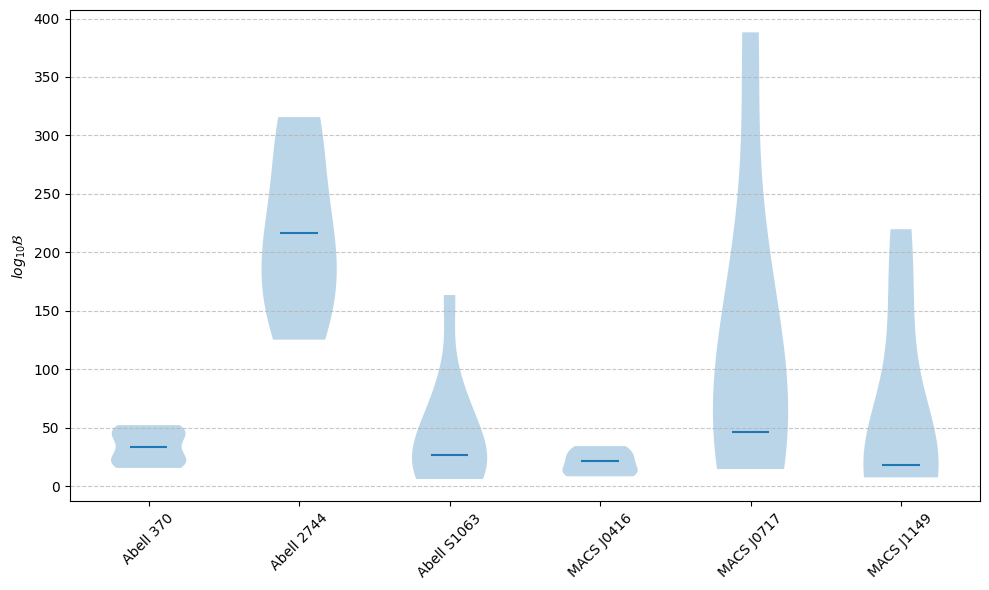

In [18]:
# make a graph that list the cluster in x axis, and the corresponding bayes factor in y axis
# The filtered_bayes_factors and filtered_localized_index are from cell 10
# bayes_factors are already in log10 scale from cell 7 logic, which is then filtered in cell 10
log10_bayes_factors = [bf * np.log10(np.e) for bf in filtered_bayes_factors]

plt.figure(figsize=(10, 6))
# Group Bayes factors by cluster index
data_to_plot = [[] for _ in range(6)]
for index, bf in zip(filtered_localized_index, log10_bayes_factors):
    data_to_plot[int(index)].append(bf)

# Create a violin plot which is like a histogram for each category
plt.violinplot(data_to_plot, positions=np.arange(0, 6), showmedians=True, showextrema=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel(r'$log_{10} \mathcal{B}$')
plt.xticks(ticks=np.arange(0, 6), labels=['Abell 370', 'Abell 2744', 'Abell S1063', 'MACS J0416', 'MACS J0717', 'MACS J1149'], rotation=45)
plt.tight_layout()
#plt.savefig('Report images sem2/new/B_vs_cluster_xyz.pdf', bbox_inches='tight')